In [1]:
import numpy as np
import scipy
import scipy.spatial
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import speechpy
from pydub import AudioSegment
from matplotlib.patches import ConnectionPatch
%matplotlib inline

In [2]:
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = None

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/868284962.py:11: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['image.interpolation'] = None


In [3]:
t1 = 'english1_stella.mp3'
t2 = 'english2_stella.mp3'
t3 = 'korean1_stella.mp3'
t4 = 'korean2_stella.mp3'

path_2 = './english_recordings/test/'

In [4]:
y_t1, sr = librosa.load(path_2+t1)
y_t2, _ = librosa.load(path_2+t2)
y_t3, _ = librosa.load(path_2+t3)
y_t4, _ = librosa.load(path_2+t4)

/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [5]:
hop_length = int(0.01 * sr)
n_fft = int(0.025 * sr)
print(hop_length, n_fft)

220 551


In [6]:
def trimSound(path, filename, trim_times):
    sound = AudioSegment.from_file(path+filename, format='mp3')
    trim = sound[trim_times[0]*1000:trim_times[1]*1000]
    return trim

def trimSave(trim, path, filename):
    trim.export(path + filename, format='mp3')

In [7]:
def getMFCC(signal, n_mfcc, sr, hop_length, n_fft):
    mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
    mfccs = mfccs[1:,]
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    return comprehensive_mfccs

def showMFCC(mfcc, sr, hop_length, n_fft):
    librosa.display.specshow(mfcc,
                        x_axis="time",
                        sr = sr,
                        hop_length = hop_length,
                        n_fft = n_fft)
    plt.colorbar(format="%+2.f")
    plt.show()

In [8]:
def amplitude_envelope(signal, n_fft, hop_length):
    return np.array([max(signal[i:i+n_fft]) for i in range(0, len(signal), hop_length)])

In [9]:
def pad(ae, target_len):
    return np.pad(ae, (0, target_len-ae.size))

In [10]:
def getMFCCNorm(mfcc):
    norm = speechpy.processing.cmvn(mfcc.T, variance_normalization=True)
    return norm.T

In [11]:
def DTW(ref_mfcc, comp_mfcc):
    D, wp = librosa.sequence.dtw(X=ref_mfcc, Y=comp_mfcc, metric='euclidean', backtrack=True)
    wp_s = np.asarray(wp) * hop_length / sr
    return D, wp, wp_s

In [12]:
def plotDTW(D, wp_s):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    librosa.display.specshow(D, x_axis='time', y_axis='time',
                             cmap='gray_r', hop_length=hop_length)
    ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
    plt.title('Warping Path on Acc. Cost Matrix $D$')
    plt.colorbar()

In [13]:
def plotAlign(sig1, sig2):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(12, 8))

    # Plot x_2
    librosa.display.waveshow(sig2, sr=sr, ax=ax2)
    ax2.set(title='comparison')

    # Plot x_1
    librosa.display.waveshow(sig1, sr=sr, ax=ax1)
    ax1.set(title='reference')
    ax1.label_outer()

    n_arrows = 20
    for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
        # Create a connection patch between the aligned time points
        # in each subplot
        con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                              axesA=ax1, axesB=ax2,
                              coordsA='data', coordsB='data',
                              color='r', linestyle='--',
                              alpha=0.5)
        ax2.add_artist(con)

In [14]:
def getDiff(ref_mfcc, comp_mfcc, wp):
    x = np.linspace(0, ref_mfcc.shape[1]-1, ref_mfcc.shape[1])
    re_wp = wp[::-1]
    y = [0] * ref_mfcc.shape[1]
    sig1 = 0
    for a, b in re_wp:
        val = max(0, (sum(np.abs(ref_mfcc[:,a]))-sum(np.abs(comp_mfcc[:,b])))/sum(np.abs(ref_mfcc[:,a])))
        if sig1 == a:
            y[a] = min(y[a],val)
        else:
            y[a] = min(1, val)
            sig1 = a
    return x, y, re_wp

In [132]:
def plotAll(x,y,ref_ae,comp_ae):
    if comp_ae.size < x.size:
        comp_ae = pad(comp_ae, x.size)
    plt.plot(x,y, label="MFCC_Diff", color="r", linestyle='--')
    plt.plot(x,ref_ae, label="ref", color = 'darkblue', )
    plt.plot(x,comp_ae, label="comp", color = 'skyblue',)
    plt.xlabel("frames")
    plt.ylim([0, 1])
    plt.legend()

In [59]:
def onsetDetect(signal, sr, hop_length, n_fft):
    onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
    onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length, n_fft=n_fft)
    trim_frames = []
    trim_frames.append(onset_frames_back[0]-1)
    trim_frames.append(onset_frames[-1]+2)
    trim_times = librosa.frames_to_time(trim_frames, sr=sr, hop_length=hop_length, n_fft = n_fft)
    return trim_frames, trim_times

def drawOnset(signal, trim_times, sr):
    librosa.display.waveshow(signal, sr=sr)
    plt.vlines(trim_times, min(signal), max(signal), color='r', alpha=0.8)

---

# 1. Pre-processing

In [16]:
y_t1 = librosa.effects.preemphasis(y_t1)
y_t2 = librosa.effects.preemphasis(y_t2)
y_t3 = librosa.effects.preemphasis(y_t3)
y_t4 = librosa.effects.preemphasis(y_t4)

In [17]:
y_t1_trim, _ = librosa.effects.trim(y_t1, top_db = 25)
y_t2_trim, _ = librosa.effects.trim(y_t2, top_db = 25)
y_t3_trim, _ = librosa.effects.trim(y_t3, top_db = 25)
y_t4_trim, _ = librosa.effects.trim(y_t4, top_db = 25)

In [18]:
t1_mfcc = getMFCC(y_t1_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t2_mfcc = getMFCC(y_t2_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t3_mfcc = getMFCC(y_t3_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t4_mfcc = getMFCC(y_t4_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00341707 -0.00386438
  0.00052465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00128906  0.00211517
  0.00058655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.00117404 -0.00032882
  0.00042193] as keyword args. From version 0.10 passing these as positional 

In [19]:
t1_mfcc_norm = getMFCCNorm(t1_mfcc)
t2_mfcc_norm = getMFCCNorm(t2_mfcc)
t3_mfcc_norm = getMFCCNorm(t3_mfcc)
t4_mfcc_norm = getMFCCNorm(t4_mfcc)

In [20]:
t1_ae = amplitude_envelope(y_t1_trim, n_fft, hop_length)
t2_ae = amplitude_envelope(y_t2_trim, n_fft, hop_length)
t3_ae = amplitude_envelope(y_t3_trim, n_fft, hop_length)
t4_ae = amplitude_envelope(y_t4_trim, n_fft, hop_length)

## Test 1: t1 vs t2 (native male v native female)

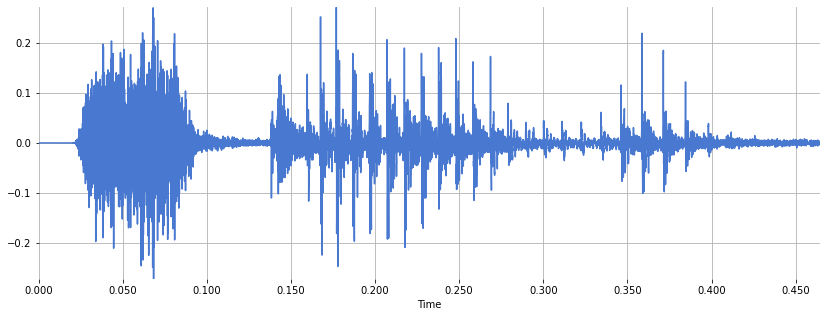

In [23]:
librosa.display.waveshow(y_t1_trim, sr=sr)

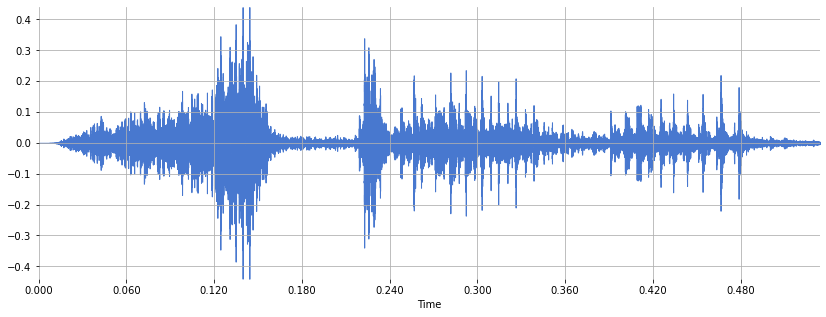

In [24]:
librosa.display.waveshow(y_t2_trim, sr=sr)

In [22]:
c = scipy.signal.correlate(y_t1_trim, y_t2_trim, mode="valid", method="fft")
peak = np.argmax(c)
offset = peak/sr
offset

0.008344671201814058

In [25]:
zeros = np.zeros((int(offset*sr)),)
tmp = np.concatenate((zeros, y_t2_trim), axis=0)

In [26]:
diff = librosa.get_duration(y_t1_trim) - librosa.get_duration(tmp)
diff

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2058312877.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00341707 -0.00386438
  0.00052465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(y_t1_trim) - librosa.get_duration(tmp)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2058312877.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00128906  0.00211517
  0.00058655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(y_t1_trim) - librosa.get_duration(tmp)


-0.07795918367346938

In [29]:
y_t1_trim.shape, tmp.shape

((10240,), (11959,))

In [30]:
tmp = tmp[:10240]

In [31]:
tmp_mfcc = getMFCC(tmp, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
tmp_norm = getMFCCNorm(tmp_mfcc)
tmp_ae = amplitude_envelope(tmp, n_fft, hop_length)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.00776123 -0.03059479
 -0.02750458] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/4167920513.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


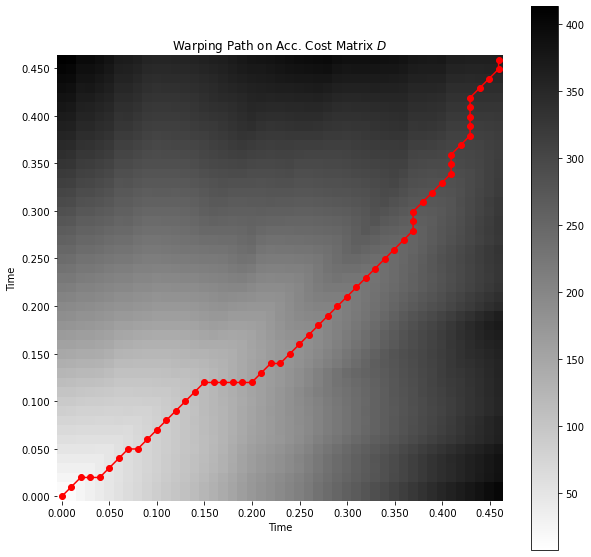

In [32]:
D, wp, wp_s = DTW(t1_mfcc_norm, tmp_norm)
plotDTW(D, wp_s)

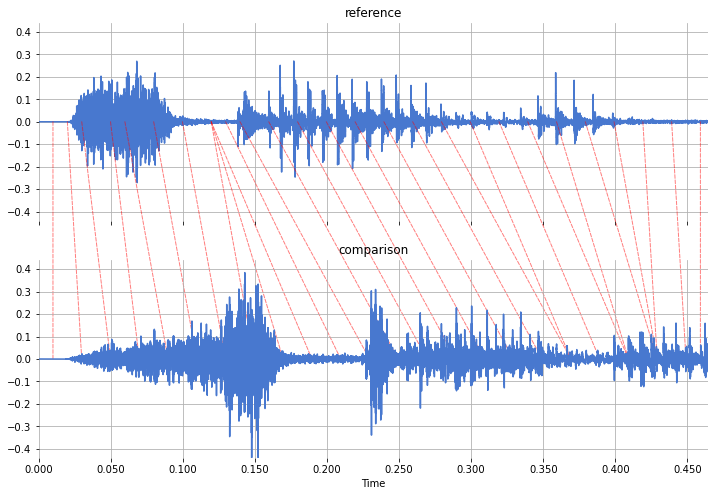

In [33]:
plotAlign(y_t1_trim, tmp)

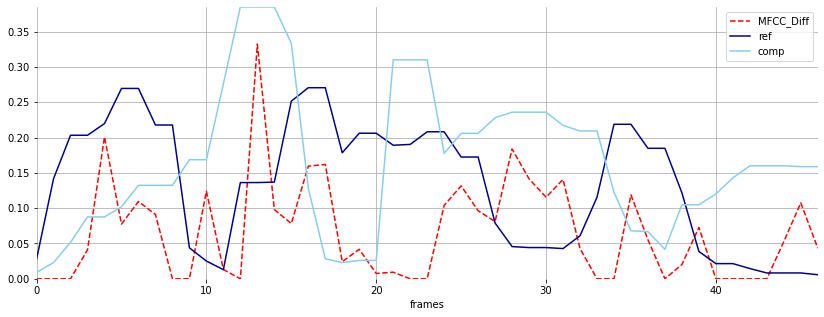

In [34]:
x, y, re_wp = getDiff(t1_mfcc_norm, tmp_norm, wp)
plotAll(x,y,t1_ae,tmp_ae)

---

## Test 2: t1 vs t3 (native male v foreign male)

In [36]:
c = scipy.signal.correlate(y_t1_trim, y_t3_trim, mode="valid", method="fft")
peak = np.argmax(c)
offset = peak/sr
offset

0.05174603174603175

In [37]:
zeros = np.zeros((int(offset*sr)),)
tmp = np.concatenate((zeros, y_t3_trim), axis=0)

In [38]:
diff = librosa.get_duration(y_t1_trim) - librosa.get_duration(tmp)
diff

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2058312877.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00341707 -0.00386438
  0.00052465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(y_t1_trim) - librosa.get_duration(tmp)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2058312877.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.00117404 -0.00032882
  0.00042193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(y_t1_trim) - librosa.get_duration(tmp)


-0.12140589569160992

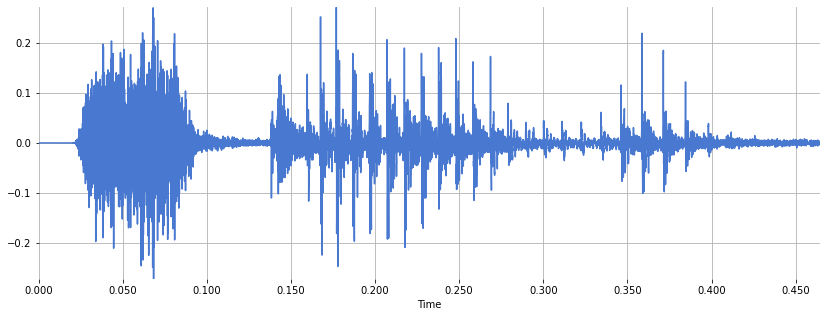

In [39]:
librosa.display.waveshow(y_t1_trim, sr=sr)

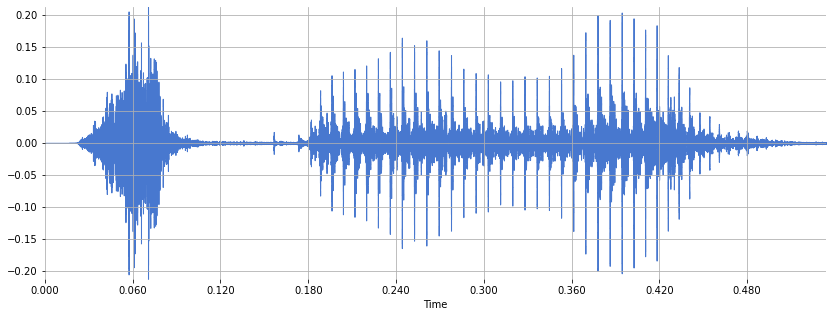

In [49]:
librosa.display.waveshow(y_t3_trim, sr=sr)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:2: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00341707 -0.00386438
  0.00052465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:3: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00341707 -0.00386438
  0.00052465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)


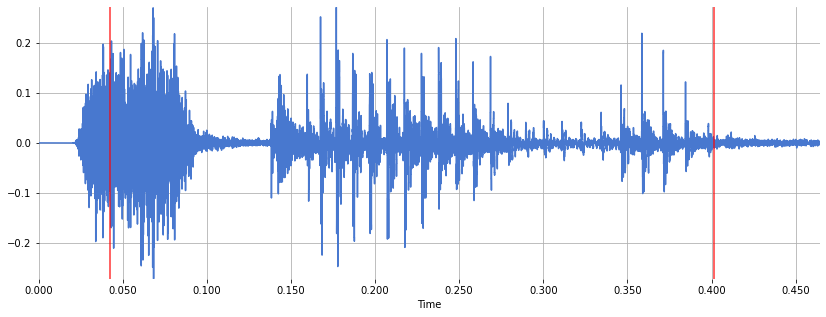

In [72]:
trim_frames, trim_times = onsetDetect(y_t1_trim, sr, hop_length, n_fft)
drawOnset(y_t1_trim, trim_times, sr)
s = y_t1_trim[int(trim_times[0]*sr):int(trim_times[1]*sr)+1]

In [77]:
s = y_t1_trim[int(trim_times[0]*sr):int(trim_times[1]*sr)+1]

In [78]:
ipd.Audio(s, rate=sr)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:2: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.00117404 -0.00032882
  0.00042193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:3: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.00117404 -0.00032882
  0.00042193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)


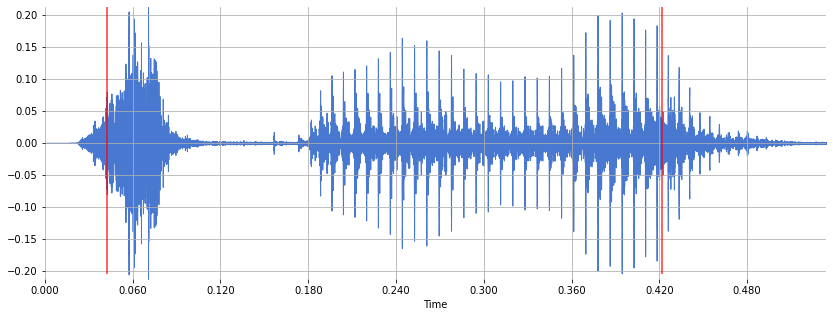

In [64]:
trim_frames, trim_times = onsetDetect(y_t3_trim, sr, hop_length, n_fft)
drawOnset(y_t3_trim, trim_times, sr)

In [67]:
trim_times

array([0.04240363, 0.42154195])

In [69]:
0.04240363*sr, 0.42154195*sr

(935.0000415, 9294.9999975)

In [70]:
s = y_t3_trim[935:9296]

In [71]:
ipd.Audio(s, rate=sr)

In [79]:
ipd.Audio(y_t3_trim, rate=sr)

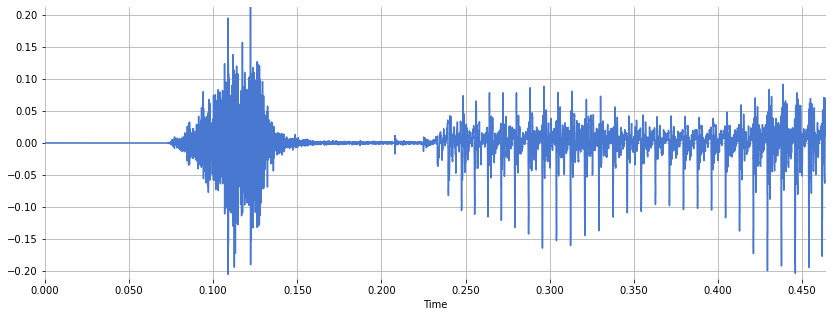

In [61]:
librosa.display.waveshow(tmp, sr=sr)

In [50]:
y_t1_trim.shape, y_t3_trim.shape

((10240,), (11776,))

In [51]:
tmp = y_t3_trim[:10240]

In [52]:
tmp_mfcc = getMFCC(tmp, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
tmp_norm = getMFCCNorm(tmp_mfcc)
tmp_ae = amplitude_envelope(tmp, n_fft, hop_length)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[0.         0.         0.         ... 0.00803031 0.00704779 0.00443655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/4167920513.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


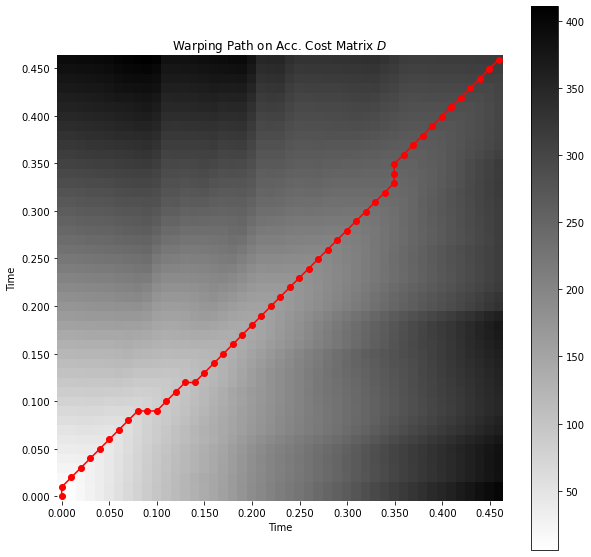

In [53]:
D, wp, wp_s = DTW(t1_mfcc_norm, tmp_norm)
plotDTW(D, wp_s)

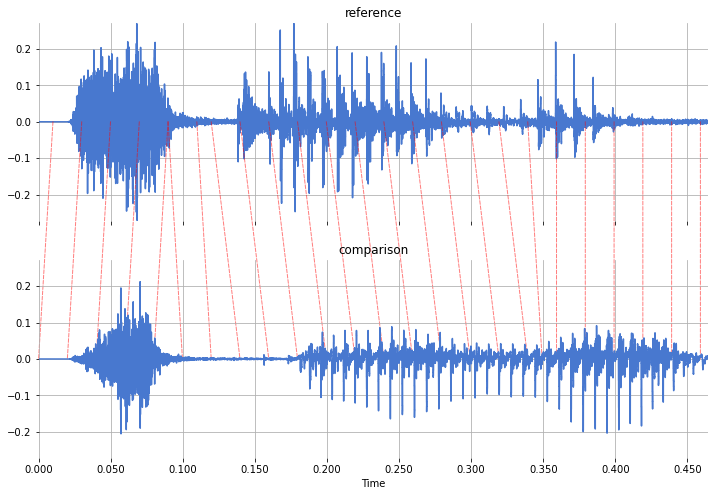

In [54]:
plotAlign(y_t1_trim, tmp)

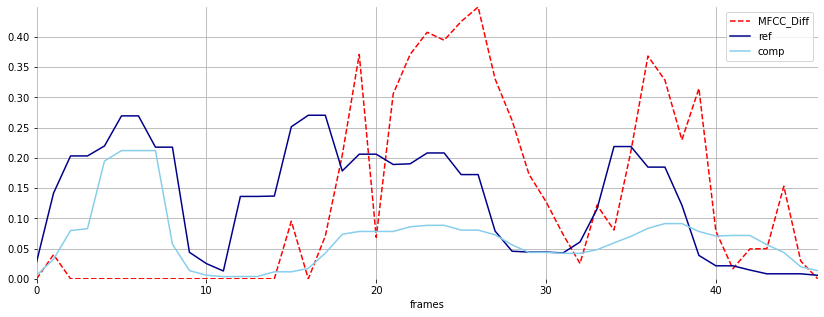

In [55]:
x, y, re_wp = getDiff(t1_mfcc_norm, tmp_norm, wp)
plotAll(x,y,t1_ae,tmp_ae)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[0.         0.         0.         ... 0.00980593 0.01259997 0.02464803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


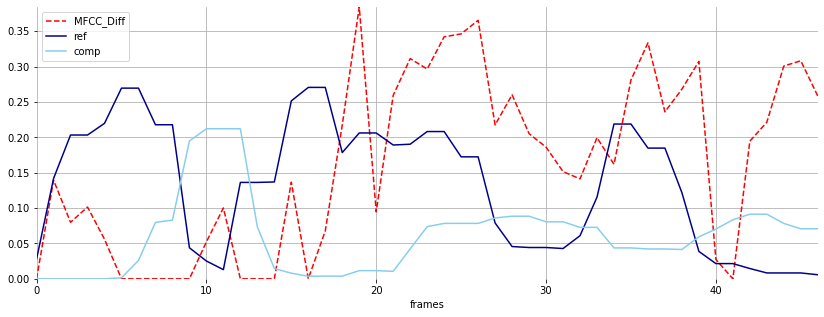

In [56]:
zeros = np.zeros((int(offset*sr)),)
tmp = np.concatenate((zeros, y_t3_trim), axis=0)
tmp = tmp[:10240]
tmp_mfcc = getMFCC(tmp, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
tmp_norm = getMFCCNorm(tmp_mfcc)
tmp_ae = amplitude_envelope(tmp, n_fft, hop_length)
D, wp, wp_s = DTW(t1_mfcc_norm, tmp_norm)
x, y, re_wp = getDiff(t1_mfcc_norm, tmp_norm, wp)
plotAll(x,y,t1_ae,tmp_ae)

In [58]:
ipd.Audio(tmp, rate=sr)

---

In [103]:
trim_frames, trim_times = onsetDetect(y_t1_trim, sr, hop_length, n_fft)
s_1 = y_t1_trim[int(trim_times[0]*sr):int(trim_times[1]*sr)+1]

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:2: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00341707 -0.00386438
  0.00052465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:3: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00341707 -0.00386438
  0.00052465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)


In [105]:
trim_frames, trim_times = onsetDetect(y_t3_trim, sr, hop_length, n_fft)
s_3 = y_t3_trim[int(trim_times[0]*sr):int(trim_times[1]*sr)+1]

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:2: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.00117404 -0.00032882
  0.00042193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:3: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.00117404 -0.00032882
  0.00042193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)


In [108]:
c = scipy.signal.correlate(s_3, s_1, mode="valid", method="fft")
peak = np.argmax(c)
offset = peak/sr
offset

0.017913832199546485

In [107]:
librosa.get_duration(s_1), librosa.get_duration(s_3)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/736121458.py:1: FutureWarning: Pass y=[-0.0616678   0.13994655 -0.05228395 ...  0.00059211  0.00172389
 -0.00525925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(s_1), librosa.get_duration(s_3)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/736121458.py:1: FutureWarning: Pass y=[ 0.00750247 -0.0559012   0.0535771  ... -0.00273971 -0.00742209
 -0.00312332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(s_1), librosa.get_duration(s_3)


(0.35922902494331066, 0.37918367346938775)

In [121]:
zeros = np.zeros((int(offset*sr)),)
tmp = np.concatenate((zeros, s_1), axis=0)

In [122]:
librosa.get_duration(tmp), librosa.get_duration(s_3)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2773922857.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.00059211  0.00172389
 -0.00525925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(tmp), librosa.get_duration(s_3)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2773922857.py:1: FutureWarning: Pass y=[ 0.00750247 -0.0559012   0.0535771  ... -0.00273971 -0.00742209
 -0.00312332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(tmp), librosa.get_duration(s_3)


(0.37714285714285717, 0.37918367346938775)

In [123]:
diff = librosa.get_duration(s_3) - librosa.get_duration(tmp)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/816478434.py:1: FutureWarning: Pass y=[ 0.00750247 -0.0559012   0.0535771  ... -0.00273971 -0.00742209
 -0.00312332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(s_3) - librosa.get_duration(tmp)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/816478434.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.00059211  0.00172389
 -0.00525925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(s_3) - librosa.get_duration(tmp)


In [124]:
zeros = np.zeros(int(round(diff*sr,0)),)
tmp = np.concatenate((tmp, zeros), axis=0)

In [125]:
tmp.shape, s_3.shape

((8361,), (8361,))

In [129]:
s1_norm.shape, s3_norm.shape

((36, 39), (36, 39))

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[ 0.00750247 -0.0559012   0.0535771  ... -0.00273971 -0.00742209
 -0.00312332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


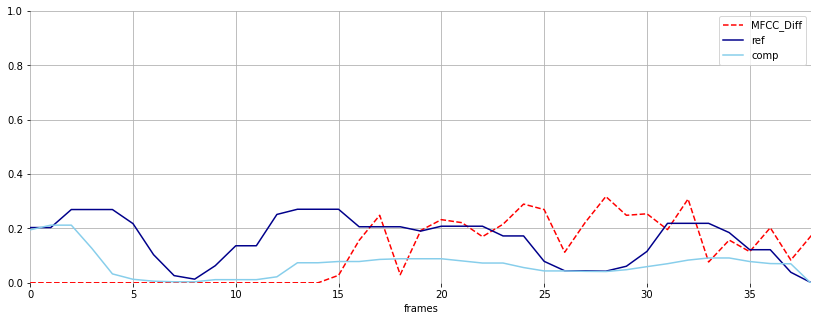

In [133]:
s1_mfcc = getMFCC(tmp, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
s1_norm = getMFCCNorm(s1_mfcc)
s1_ae = amplitude_envelope(tmp, n_fft, hop_length)
s3_mfcc = getMFCC(s_3, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
s3_norm = getMFCCNorm(s3_mfcc)
s3_ae = amplitude_envelope(s_3, n_fft, hop_length)
D, wp, wp_s = DTW(s1_norm, s3_norm)
x, y, re_wp = getDiff(s1_norm, s3_norm, wp)
plotAll(x,y,s1_ae,s3_ae)

---

## Test 3: t2 vs t4 (native female v foreign female)

In [134]:
librosa.get_duration(y_t2_trim), librosa.get_duration(y_t4_trim)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2730403617.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00128906  0.00211517
  0.00058655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t2_trim), librosa.get_duration(y_t4_trim)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2730403617.py:1: FutureWarning: Pass y=[0.         0.         0.         ... 0.00116735 0.00405922 0.00067992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t2_trim), librosa.get_duration(y_t4_trim)


(0.5340589569160997, 0.8359183673469388)

In [135]:
trim_frames, trim_times = onsetDetect(y_t2_trim, sr, hop_length, n_fft)
s_2 = y_t2_trim[int(trim_times[0]*sr):int(trim_times[1]*sr)+1]

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:2: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00128906  0.00211517
  0.00058655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:3: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00128906  0.00211517
  0.00058655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)


In [136]:
trim_frames, trim_times = onsetDetect(y_t4_trim, sr, hop_length, n_fft)
s_4 = y_t4_trim[int(trim_times[0]*sr):int(trim_times[1]*sr)+1]

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:2: FutureWarning: Pass y=[0.         0.         0.         ... 0.00116735 0.00405922 0.00067992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:3: FutureWarning: Pass y=[0.         0.         0.         ... 0.00116735 0.00405922 0.00067992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)


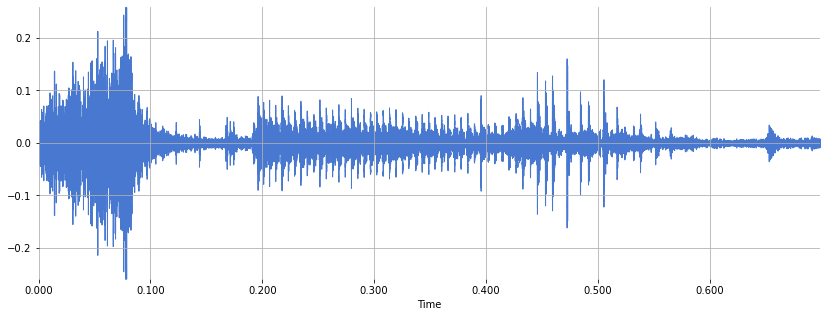

In [137]:
librosa.display.waveshow(s_4, sr=sr)

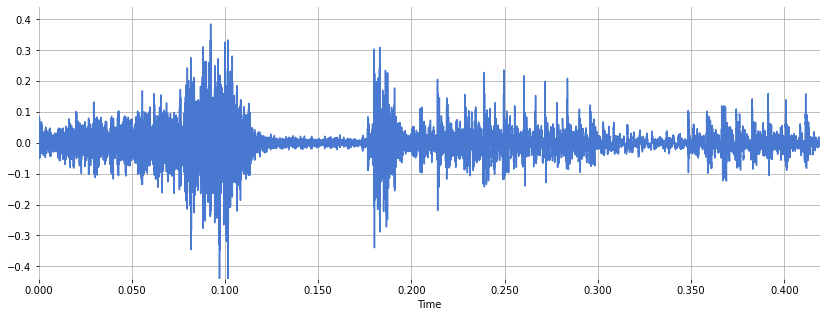

In [138]:
librosa.display.waveshow(s_2, sr=sr)

In [141]:
ipd.Audio(s_2, rate=sr)

In [142]:
ipd.Audio(s_4, rate=sr)

In [146]:
c = scipy.signal.correlate(s_2, s_4, mode="valid", method="fft")
peak = np.argmax(c)
offset = peak/sr
offset

0.07850340136054422

In [147]:
zeros = np.zeros(int(round(offset*sr,0)),)
tmp = np.concatenate((zeros, s_2), axis=0)

In [148]:
diff = librosa.get_duration(s_4) - librosa.get_duration(tmp)
diff

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/947350902.py:1: FutureWarning: Pass y=[ 4.1432194e-02 -1.7657502e-02  2.5497809e-02 ... -5.2593648e-05
 -5.9112459e-03 -1.4155358e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(s_4) - librosa.get_duration(tmp)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/947350902.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01076141 -0.01009613
 -0.00329803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(s_4) - librosa.get_duration(tmp)


0.20086167800453514

In [149]:
zeros = np.zeros(int(round(diff*sr,0)),)
tmp = np.concatenate((tmp, zeros), axis=0)

In [150]:
tmp.shape, s_4.shape

((15401,), (15401,))

In [151]:
s2_mfcc = getMFCC(tmp, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
s2_norm = getMFCCNorm(s2_mfcc)
s2_ae = amplitude_envelope(tmp, n_fft, hop_length)
s4_mfcc = getMFCC(s_4, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
s4_norm = getMFCCNorm(s4_mfcc)
s4_ae = amplitude_envelope(s_4, n_fft, hop_length)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[ 4.1432194e-02 -1.7657502e-02  2.5497809e-02 ... -5.2593648e-05
 -5.9112459e-03 -1.4155358e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/4167920513.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


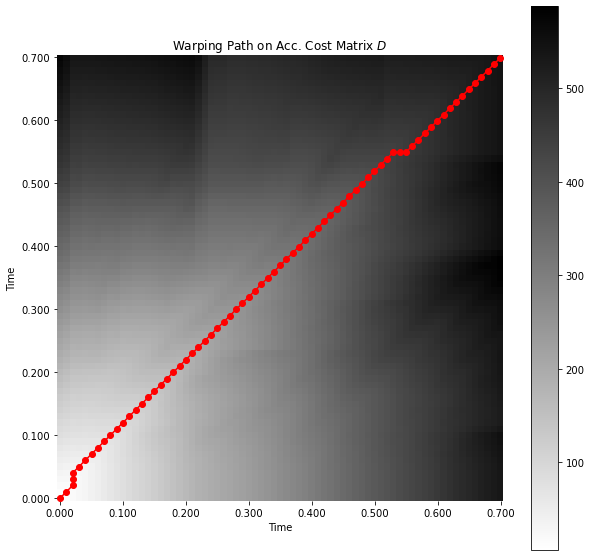

In [152]:
D, wp, wp_s = DTW(s2_norm, s4_norm)
plotDTW(D, wp_s)

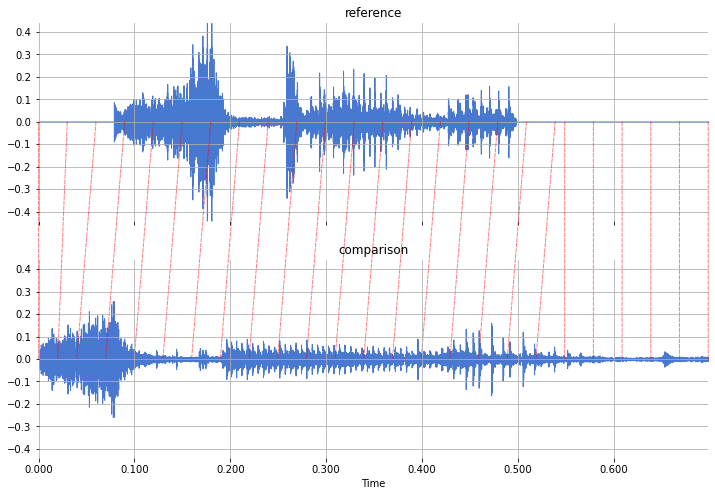

In [153]:
plotAlign(tmp, s_4)

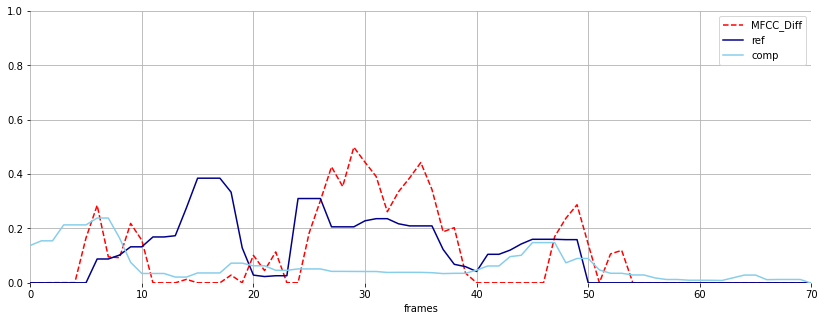

In [154]:
x, y, re_wp = getDiff(s2_norm, s4_norm, wp)
plotAll(x,y,s2_ae,s4_ae)

---

## Test 4: t2 vs t3 (native female vs foreign male)

In [157]:
s_2.shape, s_3.shape

((9241,), (8361,))

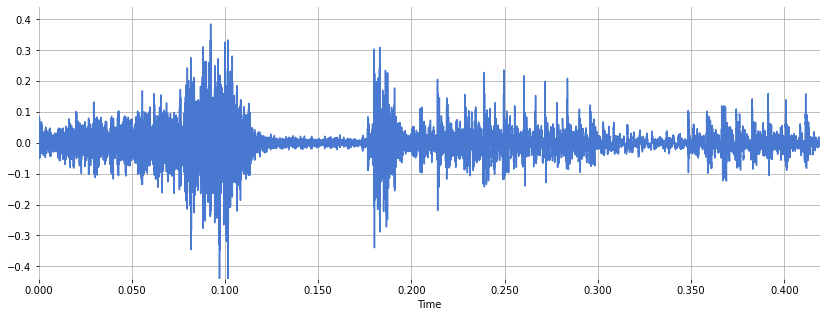

In [158]:
librosa.display.waveshow(s_2, sr=sr)

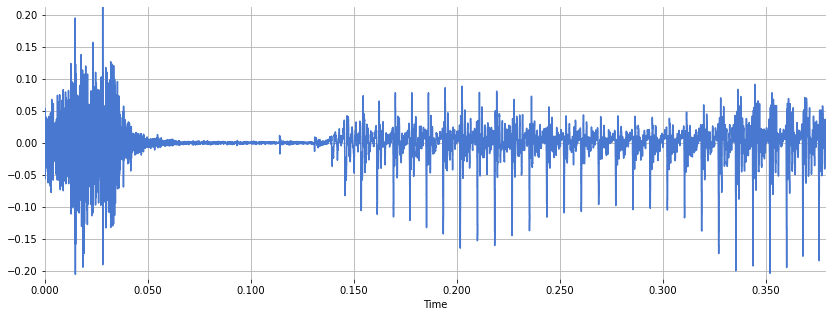

In [159]:
librosa.display.waveshow(s_3, sr=sr)

In [162]:
c = scipy.signal.correlate(s_2, s_3, mode="valid", method="fft")
peak = np.argmax(c)
offset = peak/sr
offset

0.03197278911564626

In [163]:
zeros = np.zeros(int(round(offset*sr,0)),)
tmp = np.concatenate((zeros, s_3), axis=0)

In [164]:
diff = librosa.get_duration(s_2) - librosa.get_duration(tmp)
diff

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2091252080.py:1: FutureWarning: Pass y=[-0.03644928  0.08760101 -0.04808289 ... -0.01076141 -0.01009613
 -0.00329803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(s_2) - librosa.get_duration(tmp)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2091252080.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00273971 -0.00742209
 -0.00312332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(s_2) - librosa.get_duration(tmp)


0.007936507936507908

In [165]:
zeros = np.zeros(int(round(diff*sr,0)),)
tmp = np.concatenate((tmp, zeros), axis=0)

In [166]:
tmp.shape, s_2.shape

((9241,), (9241,))

In [167]:
s2_mfcc = getMFCC(s_2, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
s2_norm = getMFCCNorm(s2_mfcc)
s2_ae = amplitude_envelope(s_2, n_fft, hop_length)
s3_mfcc = getMFCC(tmp, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
s3_norm = getMFCCNorm(s3_mfcc)
s3_ae = amplitude_envelope(tmp, n_fft, hop_length)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[-0.03644928  0.08760101 -0.04808289 ... -0.01076141 -0.01009613
 -0.00329803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/4167920513.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


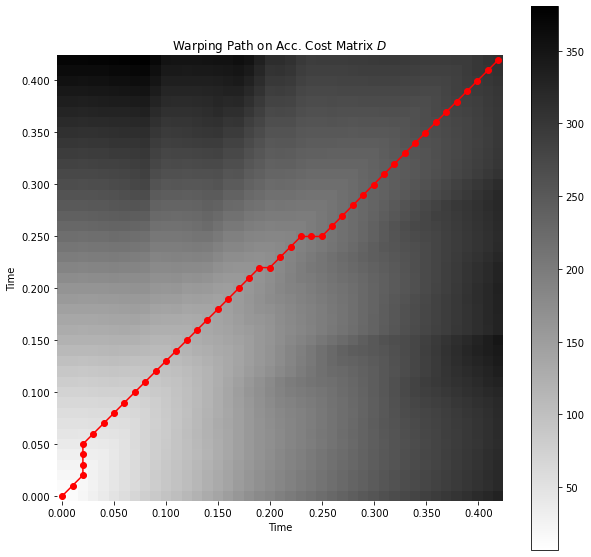

In [168]:
D, wp, wp_s = DTW(s2_norm, s3_norm)
plotDTW(D, wp_s)

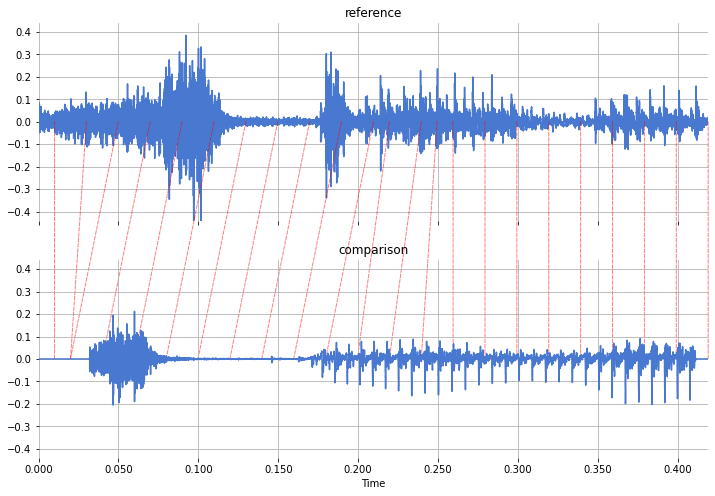

In [169]:
plotAlign(s_2, tmp)

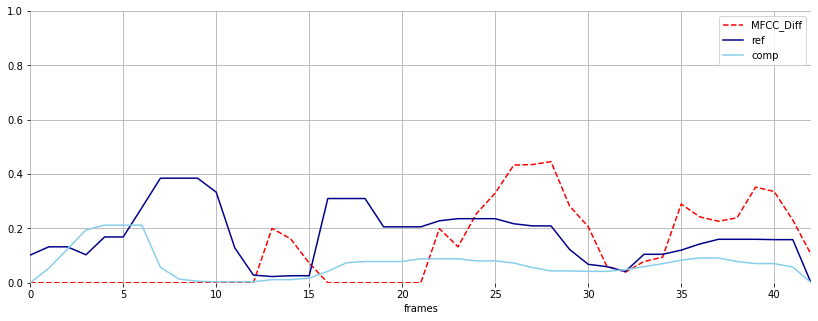

In [170]:
x, y, re_wp = getDiff(s2_norm, s3_norm, wp)
plotAll(x,y,s2_ae,s3_ae)

---

## Test 5: Stella v Train Station

In [171]:
t5 = 'english1_ts.mp3'

In [172]:
y_t5, _ = librosa.load(path_2 + t5)

/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [175]:
y_t5 = librosa.effects.preemphasis(y_t5)
y_t5_trim, _ = librosa.effects.trim(y_t5, top_db = 25)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:2: FutureWarning: Pass y=[-9.3067443e-05  6.0382305e-04 -2.2955502e-04 ...  1.1997635e-03
 -3.6935434e-03 -2.6867632e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/1778198290.py:3: FutureWarning: Pass y=[-9.3067443e-05  6.0382305e-04 -2.2955502e-04 ...  1.1997635e-03
 -3.6935434e-03 -2.6867632e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)


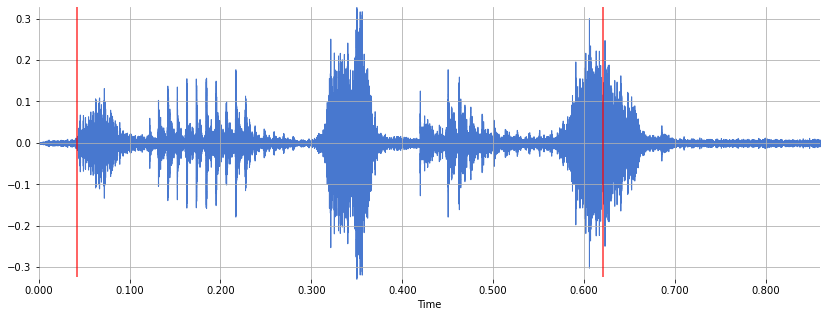

In [176]:
trim_frames, trim_times = onsetDetect(y_t5_trim, sr, hop_length, n_fft)
drawOnset(y_t5_trim, trim_times, sr)

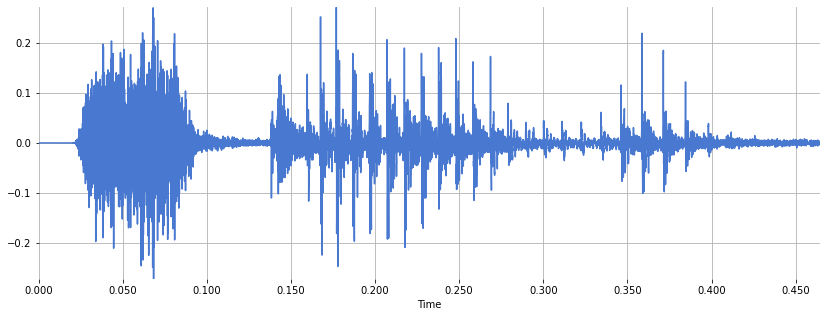

In [184]:
librosa.display.waveshow(y_t1_trim, sr=sr)

In [187]:
t5_mfcc = getMFCC(y_t5_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t5_mfcc_norm = getMFCCNorm(t5_mfcc)
t5_ae = amplitude_envelope(y_t5_trim, n_fft, hop_length)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/2534493437.py:2: FutureWarning: Pass y=[-9.3067443e-05  6.0382305e-04 -2.2955502e-04 ...  1.1997635e-03
 -3.6935434e-03 -2.6867632e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_17250/4167920513.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


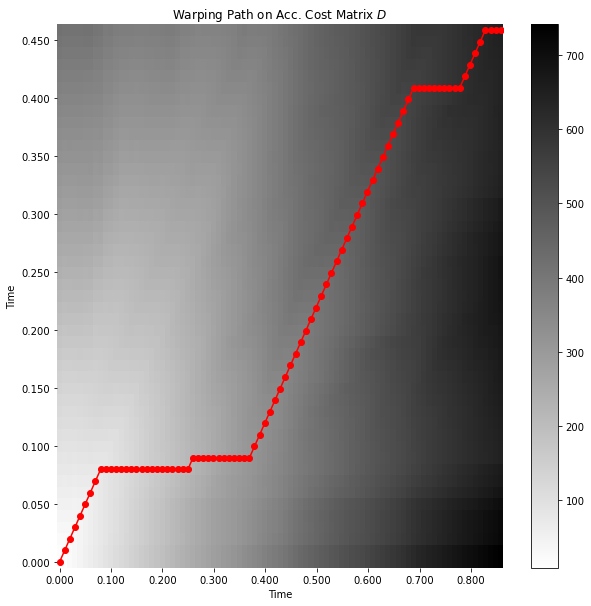

In [189]:
D, wp, wp_s = DTW(t1_mfcc_norm, t5_mfcc_norm)
plotDTW(D, wp_s)

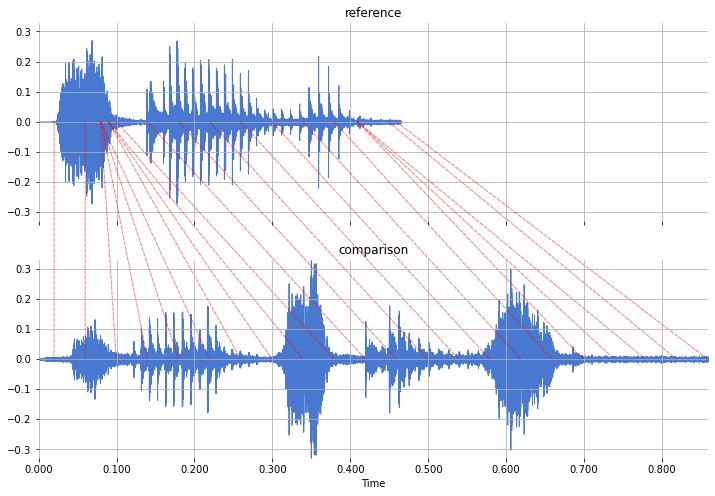

In [190]:
plotAlign(y_t1_trim, y_t5_trim)

In [194]:
t1_mfcc_norm.shape,t5_mfcc_norm.shape, t5_ae.shape

((36, 47), (36, 87), (87,))

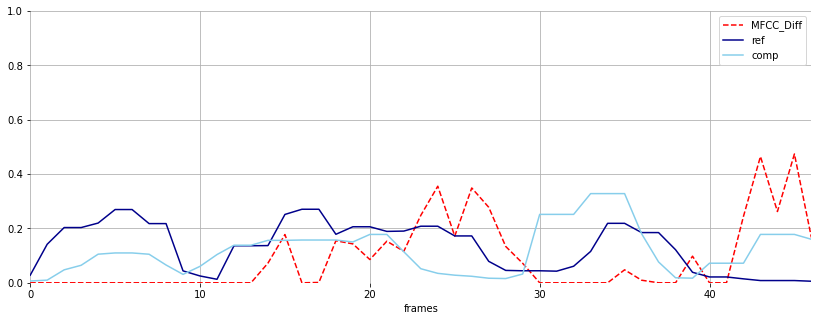

In [195]:
x, y, re_wp = getDiff(t1_mfcc_norm, t5_mfcc_norm, wp)
plotAll(x,y,t1_ae,t5_ae[:47])